# Make token vocabulary
Train a tokenizer on the Tira ASR dataset

In [334]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from transformers import WhisperTokenizer
import pandas as pd
import numpy as np
import seaborn
import string
from clap.encoders import *
from transformers import DebertaV2Tokenizer, AutoProcessor
import torch
from scipy.spatial.distance import cdist, cosine, squareform
from tqdm import tqdm
tqdm.pandas()
from unidecode import unidecode
import random
import json

In [255]:
metadata='/Users/markjos/projects/malachor5/data/tira-clean/metadata.csv'

In [256]:
unk = "[UNK]"
trainer=trainers.BpeTrainer(vocab_size=1200, special_tokens=[unk], max_token_length=8, min_frequency=40)

In [257]:
df=pd.read_csv(metadata)
def get_text_corpus():
    train_df=df[df['split']=='train']
    for row in train_df['transcription']:
        yield row

In [258]:
tokenizer = Tokenizer(models.BPE())
tokenizer.train_from_iterator(get_text_corpus(), trainer=trainer)

In [259]:
i=random.randint(0,len(df))
line=df['transcription'].iloc[i]
encoding=tokenizer.encode(line)

line, encoding.tokens, encoding.ids

('īgánònà ìjò t̪ówànî́',
 ['ī', 'g', 'ánò', 'nà ', 'ìj', 'ò ', 't̪ó', 'w', 'àn', 'î', '́'],
 [335, 7, 417, 71, 105, 210, 230, 22, 231, 214, 37])

In [260]:
tira_vocab=tokenizer.get_vocab()
tira_vocab, len(tira_vocab)

({'ɔ́ ð': 312,
  'ùɽ': 233,
  'vr̀': 318,
  'dɔ̀ɽɔ̀ ': 152,
  'ɔ̀n': 674,
  'láv': 703,
  'ku': 584,
  'gɔ̀': 593,
  'áɾ': 263,
  't̪ò': 199,
  'ŋɛ̀': 486,
  'lɛ̀ðɔ́ ': 367,
  'nà': 167,
  'nd': 55,
  'ŋáv': 284,
  'ré ': 502,
  'árt̪ɔ́': 577,
  'w': 22,
  'bàcʊ́': 677,
  'àvr': 309,
  'ǹ': 253,
  'pr': 184,
  'lì': 126,
  'ŋāvè': 630,
  'lɛ̀mù': 689,
  'màɽ': 409,
  'ðɛ́n ': 488,
  't̪ɔ́ ŋ': 266,
  'ɾɛ̀': 72,
  'ðìɲ': 332,
  'ɔ́ ŋì': 675,
  'lá ': 137,
  'o': 15,
  'lâɾù ': 403,
  'ǎ ': 244,
  'lí': 191,
  'kə́': 324,
  'ɽù': 701,
  'ŋìnà ': 498,
  'ám': 224,
  'c': 4,
  'ɔ̀ɽɟɛ̀': 439,
  'íɲá ': 456,
  'r únɛ̀': 683,
  ' nd̪': 694,
  '̂': 38,
  'ðô': 601,
  'ŋì': 140,
  'kɛ́': 479,
  'ɛ̀': 44,
  'ɛ̌n ': 513,
  'ʊ̀m': 706,
  'v': 21,
  'ŋ́': 680,
  'ðùɽ': 330,
  'dí ': 436,
  'lɔ́': 255,
  'ìnɔ́ ': 450,
  'ná': 518,
  'vlà ': 465,
  'lɛ́': 128,
  'óndì ': 469,
  'ɲá ': 529,
  'cà': 418,
  'dɔ̀': 108,
  'lù': 133,
  'ðə̀ŋ': 613,
  'ŋāv': 621,
 

In [261]:
vocab_lens=[]
for item in tira_vocab:
    vocab_lens.append(len(item.strip().replace('#', '')))
np.array(vocab_lens).mean()

3.6638537271448666

<Axes: >

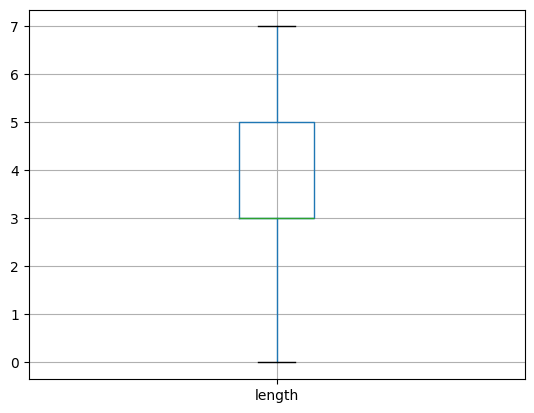

In [262]:
pd.DataFrame({'length':vocab_lens}).boxplot('length')

In [263]:
tira_id2tok={v:k for k, v in tira_vocab.items()}
tira_id2tok=pd.Series(tira_id2tok).sort_index().to_numpy()
tira_id2tok

array(['[UNK]', ' ', 'a', 'b', 'c', 'd', 'e', 'g', 'h', 'i', 'j', 'k',
       'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'ð', 'ŋ',
       'ɔ', 'ə', 'ɛ', 'ɜ', 'ɟ', 'ɭ', 'ɲ', 'ɽ', 'ɾ', 'ʃ', 'ʊ', '̀', '́',
       '̂', '̄', '̌', '̪', 'à', '́ ', 'ɛ̀', 'ɔ̀', 'á', 'ì', 'ə̀',
       'à ', 'ù', 't̪', 'ɔ́ ', 'ɔ́', 'í', 'nd', 'ɛ́', 'ú', 'ɔ̀ ',
       'bà', 'nd̪', 'ɔ̀bà', 'ə́', 'nɛ̀', 'lɛ̀', 'ŋg', 'ò', 'án',
       'á ', 'lɛ̀ð', 'í ', 'nà ', 'ɾɛ̀', 'íŋg', 'là', 'və́', 'ɛ́ ',
       'lá', 'ùnɛ̀', 'ɛ̀ ', 'və̀', 'nì', 'n ', 'íŋgán', 'ó ', 'kú',
       'l ', 'və̀lɛ̀ð', 'è', 'lə̀', 'lò', 'â', 'ì ', 't̪ɔ́', 'cə̀',
       'ŋà', 'kúk', 'wə̀', 'wə̀nì', 'cə̀lò', 'kúkù', 'ɛ̂', 'ɔ̀nà ',
       'ú ', 'ár', 'ìj', 'nɔ̀ ', 'ɔ́ ŋ', 'dɔ̀', 'nɛ̀ ', 'lɛ̂', 'ðà',
       'ɔ́m', 'là ', 'və́lɛ̂', 'ó', 'və́lɛ̀ð', 'ǎ', 'áŋ', 'ɔ́nà ',
       'rnɔ̀ ', 'və́lɛ̂ð', 'rɛ̀', 'ðə́', 't̪ɔ́ ', 'ðì', 'lì', 'nɛ',
       'lɛ́', 'ɔ́mɔ̀ ', 'nɛ́', 'dɔ̀ɽ', 'kúkù ', 'lù', 'kà', 'à

In [264]:
tira_ids=df['transcription'].apply(lambda s: tokenizer.encode(s).ids)
tira_tokenized=df['transcription'].apply(lambda s: tokenizer.encode(s).tokens)
tira_tokenized, tira_ids

(0                         [lə̀, və̀lɛ̀ð, ɛ́l , únɛ̀, ɾɛ̀]
 1                                        [kə̀ŋàc, î, í]
 2              [ŋ̀g, á, tɛ́, və́lɛ̂ð, ɔ́ nd̪, ɔ̀bà, gɛ̀]
 3        [ŋɔ́, ð, ɔ́ ŋ, á , və́lɛ̀ð, à , ðà, ŋàlà ...
 4                                    [ðə̀, və̀lè, ðɔ̀, ŋ]
                                ...                        
 20475        [ðá , nɛ́, l, ê,  , və̀lɛ̀ð, ɔ́ nd̪, ɔ̀bà]
 20476                                        [ŋə̀, vr, à]
 20477                       [ŋə̀, b, úr, ŋ, ɛ̀ , án, ó]
 20478    [lá , vŕ, ðì, t̪ɔ̀ , ku, ku, ŋu,  , ðɛ, dɔɽ...
 20479       [ùrnɔ̀ , kə̀, ŋ, a, cí , ápr, ì , kúkùŋ]
 Name: transcription, Length: 20480, dtype: object,
 0                                   [89, 87, 416, 177, 72]
 1                                           [670, 214, 54]
 2                        [323, 46, 259, 121, 160, 61, 153]
 3            [357, 23, 107, 68, 116, 49, 111, 285, 60, 61]
 4                                      [146, 66

In [265]:
tokenized_corpus_concat=np.concatenate(tira_tokenized)
tokenized_corpus_concat.shape

(149879,)

In [266]:
token_counts=pd.Series(tokenized_corpus_concat).value_counts()
token_counts[token_counts<=20].shape

(18,)

In [267]:
token_counts.mean()

211.39492242595205

In [268]:
pd.Series(tokenized_corpus_concat).unique().shape

(709,)

<Axes: >

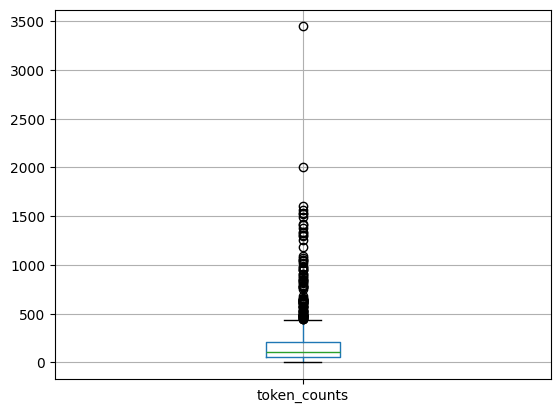

In [269]:
pd.DataFrame({'token_counts':token_counts}).boxplot('token_counts')

# Get predicted Whisper tokens
Run Whisper tokenizer on transcribed Tira ASR dataset

In [270]:
whisper_labels = '/Users/markjos/projects/malachor5/data/tira-asr/tira-clean-split-transcribed.csv'

whisper_df=pd.read_csv(whisper_labels)
whisper_df.head()

,path,croatian,split
0,HH01082021-m03s37ms011-m03s39ms552.wav,A prije jedi za hala.,train
1,HH01082021-m03s41ms371-m03s45ms023.wav,Apri-jadi-vanhala.,train
2,HH01082021-m04s43ms401-m04s46ms528.wav,A prije je vledo da hvala.,train
3,HH01082021-m04s48ms835-m04s51ms580.wav,A prije je vledo za hala.,train
4,HH01082021-m05s04ms737-m05s07ms762.wav,Apre je vledo za mala.,train


First, let's merge the Whisper and Tira metadata

In [271]:
df.shape, whisper_df.shape

((20480, 33), (20480, 3))

In [272]:
df_merge=pd.merge(df, whisper_df, on='path')
df_merge.shape

(20480, 35)

In [273]:
# df_merge.to_csv(metadata, index=False)

In [274]:
df=pd.read_csv(metadata)

Now let's get Whisper tokens

In [292]:
wh_tok=WhisperTokenizer.from_pretrained('openai/whisper-large-v3', language='croatian', task='transcribe')

In [293]:
remove_punct = lambda s: ''.join(c for c in s if c not in string.punctuation)
remove_num = lambda s: ''.join(c for c in s if c not in string.digits)
df['croatian_nmzd']=df['croatian']\
    .str.lower()\
    .apply(remove_punct)\
    .apply(remove_num)
croatian_ids=df['croatian_nmzd'].apply(lambda s: wh_tok.encode(s, add_special_tokens=False))
croatian_ids

0                                      [287, 73, 836, 706]
1                                     [444, 64, 22392, 72]
2        [220, 273, 6908, 1506, 371, 73, 2032, 44254, 1...
3        [45843, 3080, 297, 3680, 779, 1506, 1120, 710,...
4                                    [710, 85, 20336, 298]
                               ...                        
20475               [1120, 408, 20445, 84, 375, 360, 9120]
20476                                         [5947, 4481]
20477                             [14828, 297, 432, 19816]
20478    [635, 331, 1479, 1506, 281, 1571, 350, 378, 34...
20479          [4038, 1771, 444, 64, 10236, 72, 1882, 470]
Name: croatian_nmzd, Length: 20480, dtype: object

In [294]:
croatian_tokenized=croatian_ids.apply(wh_tok.convert_ids_to_tokens)
croatian_tokenized

0                                          [Ġl, j, ub, av]
1                                         [Ġkn, a, ĠÄį, i]
2                   [Ġ, nd, ati, Ġje, Ġv, j, ero, jat, no]
3        [Ġngo, vo, Ġn, ga, vel, Ġje, Ġda, Ġz, an, ad, ...
4                                         [Ġz, v, lez, om]
                               ...                        
20475                   [Ġda, Ġne, Ġlev, u, Ġli, Ġdo, bro]
20476                                          [Ġnav, rat]
20477                                 [Ġbor, Ġn, ge, Ġano]
20478     [Ġla, ver, de, Ġje, Ġto, go, Ġk, od, ir, ava, o]
20479                    [Ġur, no, Ġkn, a, Äį, i, Ġap, ri]
Name: croatian_nmzd, Length: 20480, dtype: object

In [295]:
croatian_tk_concat=np.concatenate(croatian_tokenized)
croatian_tk_concat.shape

(225166,)

In [296]:
croatian_tk_ct=pd.Series(croatian_tk_concat).value_counts()
croatian_tk_ct

Ġu       8106
v        7178
j        6581
Ġn       6441
ij       6384
         ... 
lon         1
lk          1
Ġmind       1
nar         1
Ġvere       1
Name: count, Length: 2429, dtype: int64

In [297]:
croatian_tk_ct.mean()

92.69905310827501

Let's make a list of only the Whisper tokens that are used and map their ids to their index in the list

<Axes: >

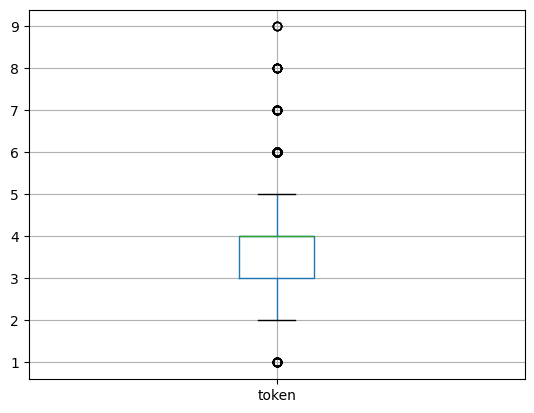

In [298]:
pd.DataFrame(data={'token':pd.Series(np.unique(croatian_tk_concat)).apply(len)}).boxplot('token')

<Axes: >

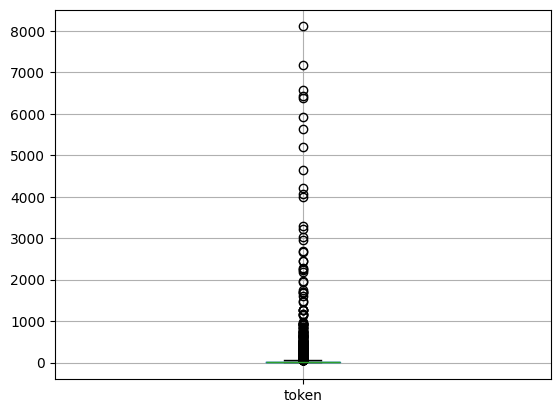

In [299]:
pd.DataFrame(data={'token':croatian_tk_ct}).boxplot('token')

In [300]:
croatian_i2whisper_tok=pd.Series(croatian_tk_concat).unique()
croatian_i2whisper_tok_id=pd.Series({i:wh_tok.convert_tokens_to_ids(tok) for i, tok in enumerate(croatian_i2whisper_tok)})
croatian_i2whisper_tok.shape, croatian_i2whisper_tok_id.shape

((2429,), (2429,))

In [301]:
croatian_i2whisper_tok[2428], croatian_i2whisper_tok_id[2428]

('Ġvere', 16443)

In [302]:
whisper_tok_id2croatian_i={v:i for i,v in enumerate(croatian_i2whisper_tok_id)}

In [303]:
croatian_i_shrunk=croatian_ids.apply(
    lambda l:[whisper_tok_id2croatian_i[i] for i in l]
)
croatian_i_shrunk

0                                             [0, 1, 2, 3]
1                                             [4, 5, 6, 7]
2                        [8, 9, 10, 11, 12, 1, 13, 14, 15]
3        [16, 17, 18, 19, 20, 11, 21, 22, 23, 24, 25, 2...
4                                         [22, 28, 29, 30]
                               ...                        
20475                       [21, 69, 601, 47, 42, 32, 197]
20476                                           [629, 401]
20477                                  [1149, 18, 75, 586]
20478    [103, 1139, 478, 11, 26, 420, 198, 121, 460, 2...
20479                     [346, 15, 4, 5, 54, 7, 347, 329]
Name: croatian_nmzd, Length: 20480, dtype: object

Plop in code from `token_alignment.ipynb`

In [304]:
def get_prob_tensors(ipa_seqs, whisper_seqs):
    ipa_vocab_size = np.max(np.concatenate(ipa_seqs))+1
    whisper_vocab_size = np.max(np.concatenate(whisper_seqs))+1

    eps=1e-8 # avoid division by zero
    cooccurr_ct = np.full([whisper_vocab_size, ipa_vocab_size], eps)
    sum_sqd_dist = np.zeros_like(cooccurr_ct)
    return sum_sqd_dist, cooccurr_ct

def initialize_probs(ipa_seqs, whisper_seqs):
    eps=1e-8
    sum_sqd_dist, cooccurr_ct=get_prob_tensors(ipa_seqs, whisper_seqs)
    for ipa_seq, whisper_seq in zip(ipa_seqs, whisper_seqs):
        for i, ipa_token in enumerate(ipa_seq):
            i_relative=i/len(ipa_seq)
            for j, whisper_token in enumerate(whisper_seq):
                j_relative=j/len(whisper_seq)
                sum_sqd_dist[whisper_token,ipa_token]+=1/((i_relative-j_relative)**2+eps)
                cooccurr_ct[whisper_token,ipa_token]+=1
    prob_unnorm = torch.tensor(sum_sqd_dist/cooccurr_ct)
    prob_norm=torch.nn.functional.softmax((prob_unnorm),dim=1)
    return prob_norm.numpy()

In [305]:
sum_sqd_dist, cooccurr_ct = get_prob_tensors(tira_ids, croatian_i_shrunk)
sum_sqd_dist.shape, cooccurr_ct.shape

((2429, 711), (2429, 711))

In [306]:
prob_mat=initialize_probs(tira_ids, croatian_i_shrunk)

<Axes: >

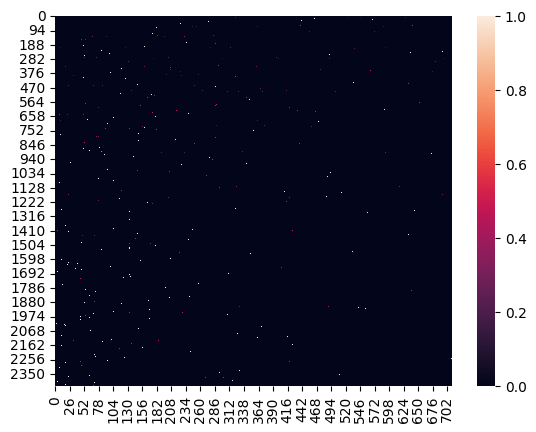

In [307]:
seaborn.heatmap(prob_mat)

# For each Tira token, get the most probable Whisper token

In [308]:
max_whisper_tokens=np.argmax(prob_mat, axis=0)
max_whisper_tokens.shape

(711,)

In [309]:
i=5
croatian_i2whisper_tok[max_whisper_tokens[i]], tira_id2tok[i]

('Ġlady', 'd')

In [310]:
np.unique(max_whisper_tokens).shape

(662,)

Let's make another matrix which is the cosine similarity of Whisper tokens to Tira tokens using CLAP-IPA phone embeddings

In [311]:
phone_encoder = PhoneEncoder.from_pretrained('anyspeech/clap-ipa-tiny-phone')
phone_encoder.eval()

clap_tok = DebertaV2Tokenizer.from_pretrained('charsiu/IPATokenizer')

ipa_input = clap_tok(
	['apri'],
	return_tensors='pt', # these kwargs avoid bugs
	return_token_type_ids=False,
	padding=True,
)

with torch.no_grad():
   phone_embed = phone_encoder(**ipa_input)['pooler_output']

In [312]:
tira_tok_input= clap_tok(
    [s.replace('#', '') for s in tira_id2tok.tolist()],
    return_tensors='pt', # these kwargs avoid bugs
    return_token_type_ids=False,
    padding=True,
)

with torch.no_grad():
    tira_id2_tok_embed=phone_encoder(**tira_tok_input)['pooler_output']

tira_id2_tok_embed.shape

torch.Size([711, 384])

In [313]:
croatian_tok_input= clap_tok(
    [s.replace('Ġ', '') for s in croatian_i2whisper_tok.tolist()],
    return_tensors='pt', # these kwargs avoid bugs
    return_token_type_ids=False,
    padding=True,
)

with torch.no_grad():
    croatian_id2_tok_embed=phone_encoder(**croatian_tok_input)['pooler_output']

croatian_id2_tok_embed.shape

torch.Size([2429, 384])

In [314]:
cos_distance = cdist(croatian_id2_tok_embed,tira_id2_tok_embed,cosine)
similarity=-1*(cos_distance-1)
similarity.shape

(2429, 711)

In [315]:
similarity=torch.tensor(similarity).softmax(dim=1).numpy()

<Axes: >

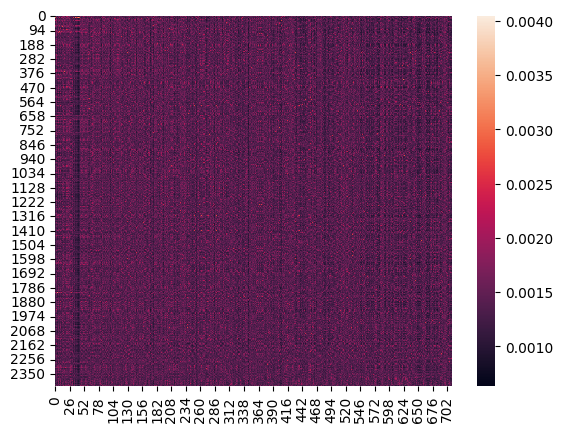

In [316]:
seaborn.heatmap(similarity)

In [317]:
max_whisper_tokens_embeds=np.argmax(similarity, axis=0)
max_whisper_tokens_embeds.shape

(711,)

In [318]:
i=700
croatian_i2whisper_tok[max_whisper_tokens_embeds[i]], tira_id2tok[i]

('Ī', 'ɛ̄')

In [319]:
np.unique(max_whisper_tokens_embeds).shape

(321,)

What if we do the opposite direction?

In [320]:
max_tira_tokens=np.argmax(prob_mat, axis=1)
max_tira_tokens.shape

(2429,)

In [321]:
max_tira_tokens_embeds=np.argmax(similarity, axis=1)
max_tira_tokens_embeds.shape

(2429,)

In [322]:
np.unique(max_tira_tokens).shape, np.unique(max_tira_tokens_embeds).shape

((578,), (404,))

In [323]:
l_unique=np.zeros(1_000)
l_shape_mismatch=np.zeros(1_000)
tira_token_lens=pd.Series(tira_id2tok).apply(len)
whisper_token_lens=pd.Series(croatian_i2whisper_tok).apply(lambda s:s.replace('Ġ', '')).apply(len)
for i in tqdm(range(1_000)):
    l=i/1_000
    combined_prob=l*prob_mat+(1-l)*similarity
    max_whisper_tokens_combined=np.argmax(combined_prob, axis=0)
    l_unique[i]=np.unique(max_whisper_tokens_combined).shape[0]
    max_whisper_token_lens=pd.Series(max_whisper_tokens_combined).apply(lambda wh_i:whisper_token_lens[wh_i])
    l_shape_mismatch[i]=np.square(tira_token_lens-max_whisper_token_lens).mean()
uniquest_l=np.argmax(l_unique)
shapliest_l=np.argmin(l_shape_mismatch)
uniquest_l, l_unique[uniquest_l], shapliest_l, l_shape_mismatch[shapliest_l]

100%|██████████| 1000/1000 [00:27<00:00, 36.87it/s]


(40, 681.0, 0, 2.779184247538678)

<Axes: >

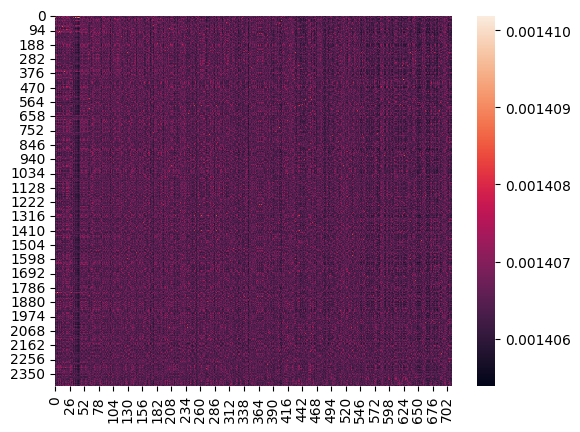

In [324]:
l=0#uniquest_l/1_000
combined_prob=l*prob_mat+(1-l)*similarity
combined_prob=torch.tensor(combined_prob).softmax(dim=1).numpy()
seaborn.heatmap(combined_prob)

In [325]:
max_whisper_tokens_combined=np.argmax(combined_prob, axis=0)
np.unique(max_whisper_tokens_combined).shape

(321,)

In [326]:
tira_id2whisper_id={}
combined_prob_copy=similarity.copy()#combined_prob.copy()
for i, col in enumerate(combined_prob_copy.T):
    max_whisper_i=np.argmax(col)
    combined_prob_copy[max_whisper_i]=float('-inf')
    tira_id2whisper_id[i]=croatian_i2whisper_tok_id[max_whisper_i]
tira_id2whisper_id

{0: 220,
 1: 276,
 2: 64,
 3: 65,
 4: 1914,
 5: 274,
 6: 68,
 7: 290,
 8: 71,
 9: 72,
 10: 73,
 11: 350,
 12: 287,
 13: 275,
 14: 297,
 15: 78,
 16: 280,
 17: 81,
 18: 262,
 19: 83,
 20: 84,
 21: 371,
 22: 261,
 23: 85,
 24: 6415,
 25: 277,
 26: 107,
 27: 308,
 28: 79,
 29: 66,
 30: 75,
 31: 9616,
 32: 367,
 33: 48759,
 34: 1878,
 35: 344,
 36: 67,
 37: 74,
 38: 256,
 39: 15696,
 40: 70,
 41: 16364,
 42: 257,
 43: 272,
 44: 230,
 45: 129,
 46: 40079,
 47: 741,
 48: 675,
 49: 1641,
 50: 128,
 51: 392,
 52: 1986,
 53: 18728,
 54: 361,
 55: 273,
 56: 415,
 57: 86,
 58: 1106,
 59: 31568,
 60: 580,
 61: 19481,
 62: 324,
 63: 40857,
 64: 306,
 65: 872,
 66: 1289,
 67: 969,
 68: 22714,
 69: 18320,
 70: 4247,
 71: 629,
 72: 319,
 73: 3957,
 74: 635,
 75: 1241,
 76: 10012,
 77: 3505,
 78: 44257,
 79: 5096,
 80: 4221,
 81: 3867,
 82: 77,
 83: 17017,
 84: 263,
 85: 17807,
 86: 285,
 87: 7363,
 88: 269,
 89: 476,
 90: 2295,
 91: 1445,
 92: 20601,
 93: 281,
 94: 496,
 95: 23165,
 96: 2034,
 97: 622

In [327]:
len(tira_id2whisper_id.values()), len(set(tira_id2whisper_id.values()))

(711, 711)

In [328]:
whisper_id2tira_id={v:k for k,v in tira_id2whisper_id.items()}

In [329]:
tira_tok2whisper_tok={
    tira_id2tok[k]:wh_tok.decode(v)
    for k,v in tira_id2whisper_id.items()
}
tira_tok2whisper_tok

{'[UNK]': ' ',
 ' ': ' h',
 'a': 'a',
 'b': 'b',
 'c': 'cc',
 'd': ' d',
 'e': 'e',
 'g': ' g',
 'h': 'h',
 'i': 'i',
 'j': 'j',
 'k': ' k',
 'l': ' l',
 'm': ' m',
 'n': ' n',
 'o': 'o',
 'p': ' p',
 'r': 'r',
 's': ' s',
 't': 't',
 'u': 'u',
 'v': ' v',
 'w': ' w',
 'ð': 'v',
 'ŋ': ' ng',
 'ɔ': ' o',
 'ə': '�',
 'ɛ': ' e',
 'ɜ': 'p',
 'ɟ': 'c',
 'ɭ': 'l',
 'ɲ': ' nin',
 'ɽ': ' r',
 'ɾ': 'rh',
 'ʃ': 'ps',
 'ʊ': ' u',
 '̀': 'd',
 '́': 'k',
 '̂': ' t',
 '̄': ' kg',
 '̌': 'g',
 '̪': ' tv',
 'à': ' a',
 '́ ': ' b',
 'ɛ̀': '�',
 'ɔ̀': '�',
 'á': ' aa',
 'ì': ' i',
 'ə̀': 'he',
 'à ': 'ha',
 'ù': '�',
 't̪': 'th',
 'ɔ́ ': 'oo',
 'ɔ́': 'ooo',
 'í': ' j',
 'nd': 'nd',
 'ɛ́': ' he',
 'ú': 'w',
 'ɔ̀ ': ' ho',
 'bà': ' baba',
 'nd̪': 'nt',
 'ɔ̀bà': 'oba',
 'ə́': ' ha',
 'nɛ̀': ' neh',
 'lɛ̀': 'le',
 'ŋg': 'ng',
 'ò': 'ho',
 'án': 'ann',
 'á ': 'aaa',
 'lɛ̀ð': 'bled',
 'í ': 'ih',
 'nà ': 'na',
 'ɾɛ̀': ' re',
 'íŋg': ' ing',
 'là': ' la',
 'və́': ' ve',
 'ɛ́ ': ' ej',
 'lá': 'll

In [330]:
def transliterate_to_whisper(tira_str):
    tira_tokens = tokenizer.encode(tira_str).ids
    whisper_tokens = [tira_id2whisper_id[t] for t in tira_tokens]
    whisper_str = wh_tok.decode(whisper_tokens)
    return whisper_str
i=random.randint(0,len(df))
df['transcription'][i], transliterate_to_whisper(df['transcription'][i])

('àrt̪ɔ́ ŋə́və́lɛ̀ðà èdɔ̀ɽɔ̀ t̪ɔ́wə̀nì', ' ar tong hailedace loro to oni')

Figure out what special tokens we need to add

In [337]:
wh_tok.encode('hi'), wh_tok.encode('hi', add_special_tokens=False), wh_tok.decode(wh_tok.encode('hi'))

([50258, 50291, 50360, 50364, 4954, 50257],
 [4954],
 '<|startoftranscript|><|hr|><|transcribe|><|notimestamps|>hi<|endoftext|>')

In [340]:
hi_tokens=wh_tok.encode('hi')
prefix_tokens=hi_tokens[:4]
suffix_tokens=hi_tokens[-1:]
prefix_tokens, suffix_tokens, wh_tok.decode(prefix_tokens), wh_tok.decode(suffix_tokens)

([50258, 50291, 50360, 50364],
 [50257],
 '<|startoftranscript|><|hr|><|transcribe|><|notimestamps|>',
 '<|endoftext|>')

In [331]:
def transliterate_to_whisper_ids(tira_str):
    tira_tokens = tokenizer.encode(tira_str).ids
    whisper_tokens = [tira_id2whisper_id[t] for t in tira_tokens]
    # add special tokens
    whisper_tokens=prefix_tokens+whisper_tokens+suffix_tokens
    return whisper_tokens

In [332]:
def transliterate_to_tira(whisper_str):
    whisper_tokens=wh_tok.tokenize(whisper_str)
    whisper_ids=wh_tok.convert_tokens_to_ids(whisper_tokens)
    tira_ids=[whisper_id2tira_id.get(i, wh_tok.decode(i)[0]) for i in whisper_ids]
    tira_str=''.join([tokenizer.decode([t]) if type(t) is int else t for t in tira_ids])
    return tira_str
i=random.randint(0,len(df))
tira_str = df['transcription'][i]
whisper_str=transliterate_to_whisper(tira_str)
tira_str, whisper_str, transliterate_to_tira(whisper_str)

('n̪ìt̪ə̀lɔ́ nìcə̀lò', ' n tv itha loo niculo', 'n̪ à ló o u')

The conversion is lossy, bc nothing's constraining Whisper to only use the tokens in the vocabulary. Let's address that later.

In [ ]:
df['tira_transliterated']=df['transcription'].progress_apply(transliterate_to_whisper)
df['tira_transliterated']

In [72]:
df['tira_transliterated_ids']=df['transcription'].apply(transliterate_to_whisper_ids)

In [74]:
df.to_csv(metadata, index=False)

In [66]:
metadata

'/Users/markjos/projects/malachor5/data/tira-clean/metadata.csv'

In [97]:
whisper_id2tira_tok={int(k):tira_id2tok[v] for k,v in whisper_id2tira_id.items()}
whisper_id2tira_tok

{220: '[UNK]',
 276: ' ',
 64: 'a',
 65: 'b',
 1914: 'c',
 274: 'd',
 68: 'e',
 290: 'g',
 71: 'h',
 72: 'i',
 73: 'j',
 350: 'k',
 287: 'l',
 275: 'm',
 297: 'n',
 78: 'o',
 280: 'p',
 81: 'r',
 262: 's',
 83: 't',
 84: 'u',
 371: 'v',
 261: 'w',
 85: 'ð',
 6415: 'ŋ',
 277: 'ɔ',
 107: 'ə',
 308: 'ɛ',
 79: 'ɜ',
 66: 'ɟ',
 75: 'ɭ',
 9616: 'ɲ',
 367: 'ɽ',
 48759: 'ɾ',
 1878: 'ʃ',
 344: 'ʊ',
 67: '̀',
 74: '́',
 256: '̂',
 15696: '̄',
 70: '̌',
 16364: '̪',
 257: 'à',
 272: '́ ',
 230: 'ɛ̀',
 129: 'ɔ̀',
 40079: 'á',
 741: 'ì',
 675: 'ə̀',
 1641: 'à ',
 128: 'ù',
 392: 't̪',
 1986: 'ɔ́ ',
 18728: 'ɔ́',
 361: 'í',
 273: 'nd',
 415: 'ɛ́',
 86: 'ú',
 1106: 'ɔ̀ ',
 31568: 'bà',
 580: 'nd̪',
 19481: 'ɔ̀bà',
 324: 'ə́',
 40857: 'nɛ̀',
 306: 'lɛ̀',
 872: 'ŋg',
 1289: 'ò',
 969: 'án',
 22714: 'á ',
 18320: 'lɛ̀ð',
 4247: 'í ',
 629: 'nà ',
 319: 'ɾɛ̀',
 3957: 'íŋg',
 635: 'là',
 1241: 'və́',
 10012: 'ɛ́ ',
 3505: 'lá',
 44257: 'ùnɛ̀',
 5096: 'ɛ̀ ',
 4221: 'və̀',
 3867: 'nì',
 77

# Saving token mapping
Let's create a json file in `meta` with the token mapping and also create a new WhisperTokenizer with the replaced tokens

In [98]:
token_vocab_path='/Users/markjos/projects/malachor5/meta/token_vocab.json'
with open(token_vocab_path, 'w', encoding='utf8') as f:
    json.dump(whisper_id2tira_tok, f, indent=2, ensure_ascii=False)

In [116]:
translit_tok_path='/Users/markjos/projects/malachor5/models/hf/whisper-tira-translit-tokenizer'
wh_tok.save_pretrained(translit_tok_path)

('/Users/markjos/projects/malachor5/models/hf/whisper-tira-translit-tokenizer/tokenizer_config.json',
 '/Users/markjos/projects/malachor5/models/hf/whisper-tira-translit-tokenizer/special_tokens_map.json',
 '/Users/markjos/projects/malachor5/models/hf/whisper-tira-translit-tokenizer/vocab.json',
 '/Users/markjos/projects/malachor5/models/hf/whisper-tira-translit-tokenizer/merges.txt',
 '/Users/markjos/projects/malachor5/models/hf/whisper-tira-translit-tokenizer/normalizer.json',
 '/Users/markjos/projects/malachor5/models/hf/whisper-tira-translit-tokenizer/added_tokens.json')

In [243]:
vocab_path='/Users/markjos/projects/malachor5/models/hf/whisper-tira-translit-tokenizer/vocab.json'
with open(vocab_path) as f:
    vocab=json.load(f)
vocab

{'': 50256,
 '!': 0,
 '!!': 1432,
 '!!!': 4589,
 '!!!!': 8153,
 '!!!!!': 28493,
 '!!!!!!': 50199,
 '!!!!!!!!': 28618,
 '!!"': 44556,
 '!!)': 33826,
 '!!]': 46990,
 '!"': 2963,
 '!",': 44815,
 '!".': 35323,
 "!'": 13840,
 '!(': 46824,
 '!)': 5700,
 '!*': 32854,
 '!,': 32652,
 '!.': 37817,
 '!..': 44311,
 '!...': 34205,
 '!</': 39373,
 '!?': 7323,
 '!]': 7003,
 '!âĢĭ': 15267,
 '!ãĢį': 28534,
 '"': 1,
 '"!': 18808,
 '")': 17830,
 '",': 2566,
 '"-': 34370,
 '".': 1883,
 '"...': 18332,
 '":': 29290,
 '";': 37707,
 '">': 21732,
 '"?': 8930,
 '"]': 23711,
 '#': 2,
 '$': 3,
 '%': 4,
 '%,': 8923,
 '%.': 6856,
 '&': 5,
 "'": 6,
 "'!": 30159,
 "''": 15025,
 "')": 37380,
 "',": 6098,
 "'.": 5004,
 "'...": 37474,
 "'?": 16265,
 "'D": 41063,
 "'M": 25310,
 "'RE": 39040,
 "'S": 11460,
 "'T": 18010,
 "']": 48038,
 "'d": 1116,
 "'ll": 603,
 "'m": 478,
 "'re": 434,
 "'s": 311,
 "'t": 380,
 "'ve": 600,
 '(': 7,
 '()': 45191,
 '(?)': 20396,
 ')': 8,
 ')!': 36380,
 ')"': 33739,
 ')(': 29422,
 '))': 9383,
 

In [244]:
print(len(vocab))
wh_id2tok={v:k for k,v in vocab.items()}
for wh_id, tira_tok in whisper_id2tira_tok.items():
    wh_token=wh_id2tok[wh_id]
    vocab.pop(wh_token)
    unicode_tok_ids=wh_tok.encode(tira_tok, add_special_tokens=False)
    unicode_tok_str=''.join(wh_tok.convert_ids_to_tokens(unicode_tok_ids))
    vocab[unicode_tok_str]=wh_id
len(vocab)

50253


50251

In [216]:
wh_tok_barf="zÃ¤h"
wh_tok_i=23242
tok=wh_tok.decode([wh_tok_i])
tok

'zäh'

In [218]:
byte_representation = wh_tok_barf.encode('latin-1')
byte_representation.decode('utf8')

'zäh'

In [233]:
byte_representation=tok.encode('utf8')
byte_representation.decode('raw_unicode_escape')

'zÃ¤h'

In [246]:
with open(vocab_path, 'w', encoding='utf8') as f:
    json.dump(vocab, f, indent=2, ensure_ascii=False)

In [247]:
wh_tok_translit=WhisperTokenizer.from_pretrained(translit_tok_path)

In [250]:
wh_tok_translit.decode(df['tira_transliterated_ids'][0])

'lə̀və̀lɛ̀ðɛ́l únɛ̀ɾɛ̀'

In [253]:
wh_tok_translit.push_to_hub('markjosims/whisper-large-tira-translit')

CommitInfo(commit_url='https://huggingface.co/markjosims/whisper-large-tira-translit/commit/86a77ab6e903e8e09d78c4bd7fee84e152695f3a', commit_message='Upload tokenizer', commit_description='', oid='86a77ab6e903e8e09d78c4bd7fee84e152695f3a', pr_url=None, pr_revision=None, pr_num=None)